# AtliQ Hardware Financial Analysis
TripleTen World Consultancy (TTWC)

In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; } </style>"))

<div class="alert alert-info"; style="border-left: 7px solid blue">
Hello Dima!
    
I apologize. I restarted the kernel and ran it again locally and just today I noticed that I replaced the previous version that already had your initial comments. I tried to get to this previous version but didn't find how. If you know how I can retrieve this version, please let me know. 

## Table of Contents <a id='back'></a>
* [Introduction](#intro)
* [Data Overview](#overview)
    * [Considerations](#considerations)
* [Metric Calculation and Analysis](#analysis)
    * [Performance Metrics](#metrics)
    * [Customer, Market and Channel Analysis](#customer)
    * [Product Category and Segment Analysis](#product)
    * [Discount Analysis](#discount)
* [Hypothesis Testing](#hypothesis)
* [Conclusions](#conclusion)

## Introduction <a id='intro'></a>

AtliQ Hardware is one of the leading computer hardware producers in India, with presence in different countries across Europe, Latin America and Asia. Operating as a multinational entity, AtliQ sells various types of hardware to major players, including Amazon, Best Buy and Walmart.

This year, we have been asked to conduct a comprehensive audit for AtliQ's sales and help them automate their existing data processes. This project includes financial, product and customer analyses. For this part of the project, our Financial Department, in conjunction with the Data Analytics Department, is conducting a financial Analysis for the period 2018 - 2022. The main goal is to provide AtliQ Hardware with insights into their financial performance based on revenue, costs, profit and margin analyses, enabling them to make data-driven decisions that enhance their profitability and operational efficiency. 

We will use the database provided by AtliQ, which is in SQLite format. We'll start by exploring the data and calculating relevant metrics to uncover trends and valuable insights into the current performance. We will conduct hypothesis testing to test the assumptions derived from the data and determine its statistical significance. After, we will draw conclusions and provide recommendations based on the insights gained during the analysis. Finally, we will create an interactive dashboard with relevant metrics and insights, providing AtliQ with a tool for future use.

## Data Overview <a id='overview'> </a>

We will start by importing the necessary libraries for the analysis, creating the connection to the database, and examining the content of the database to understand what tables and data we have to work with. 

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

In [4]:
# Get the names of the tables
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

table_names = cursor.fetchall()
table_names = [name[0] for name in table_names]

for table in table_names:
    print(table)

dim_customer
dim_product
fact_pre_discount
fact_manufacturing_cost
fact_gross_price
fact_sales_monthly


All the tables are relevant for our analysis. Let's take a look at the structure of each of them to get familiarized with its columns and values and confirm whether the data types are as shown in the documentation.

In [5]:
# Get column names and data types

def columns_info(table):
    cursor.execute(f"PRAGMA table_info({table});")
    
    columns = cursor.fetchall()
    
    print(f"Table - {table}:\n")
    for col in columns:
        for i in range(1, 3):
            print(col[i], sep=' - ')
        print()

In [6]:
# Customer table
columns_info('dim_customer')

Table - dim_customer:

customer_code
INTEGER

customer
TEXT

platform
TEXT

channel
TEXT

market
TEXT

sub_zone
TEXT

region
TEXT



In [7]:
# Count of distinct customers
query = """
SELECT COUNT(DISTINCT customer_code) AS customer_code_cnt,
    COUNT(DISTINCT customer) AS customer_cnt
FROM dim_customer;
"""

pd.read_sql_query(query, con)

,customer_code_cnt,customer_cnt
0,209,75


We have 75 distinct customers. However, we have over 200 distinct customer codes, since each customer is assigned different codes depending on the  platform, channel and region, in addition to the name.

We already know what are the distinct values for most columns in this table, based on the documentation. However, for the sub-zone, the documentation doesn't specify what each abbreviation stands for. Let's take a look at the different sub-zones and regions to better understand what they mean. 

In [8]:
# Distinct sub-zones
query = """
SELECT DISTINCT sub_zone, region
FROM dim_customer;
"""

pd.read_sql_query(query, con)

,sub_zone,region
0,India,APAC
1,ROA,APAC
2,ANZ,APAC
3,SE,EU
4,NE,EU
5,NA,NA
6,LATAM,LATAM


In [9]:
# Distinct markets
query = """
SELECT DISTINCT market
FROM dim_customer;
"""

market = pd.read_sql_query(query, con)['market'].tolist()
print(market)

['India', 'Indonesia', 'Japan', 'Pakistan', 'Philiphines', 'South Korea', 'Australia', 'Newzealand', 'Bangladesh', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Austria', 'United Kingdom', 'USA', 'Canada', 'Mexico', 'Brazil', 'China', 'Chile', 'Columbia']


Besides India, the different sub-zones in which AtliQ has presence are:
- ROA: rest of Asia
- ANZ: Australia and New Zeland
- SE: Southeast Europe
- NE: Northeast Europe
- NA: North America
- LATAM: Latin Ametica

For the markets, we can see two errors: 'Newzealand' instead of 'New Zealand' and 'Columbia' instead of 'Colombia'. Let's also take a look at the customers' names and verify whether we have duplicated values due to leading or trailing spaces.

In [10]:
query = """
SELECT DISTINCT(customer)
FROM dim_customer
"""

customers = pd.read_sql_query(query, con)
customers = customers['customer'].tolist()
customers.sort()
customers

customers_clean = []
for customer in customers:
    customers_clean.append(customer.rstrip())
    
customers = set(customers)
customers_clean = set(customers_clean)

difference = customers - customers_clean
difference

{'Amazon '}

We have one duplicated customer, Amazon, with an additional space at the end.

Let's continue with the `dim_product` table.

In [11]:
# Product table
columns_info('dim_product')

Table - dim_product:

product_code
TEXT

division
TEXT

segment
TEXT

category
TEXT

product
TEXT

variant
TEXT



In [12]:
# Count of distinct products
query = """
SELECT COUNT(DISTINCT product_code) AS unique_product_cnt,
    COUNT(DISTINCT category) AS category_cnt,
    COUNT(DISTINCT product) AS product_cnt,
    COUNT(DISTINCT variant) AS variant_cnt
FROM dim_product;
"""

pd.read_sql_query(query, con)

,unique_product_cnt,category_cnt,product_cnt,variant_cnt
0,397,14,73,27


Moving onto the `fact_pre_discount` table, let's take a look at the range of years we have information of, and the number of customers that have receivd discounts.

In [13]:
# Discounts table
columns_info('fact_pre_discount')

Table - fact_pre_discount:

customer_code
INTEGER

fiscal_year
INTEGER

pre_invoice_discount_pct
float



In [14]:
# Range of years
query = """
SELECT MIN(fiscal_year) AS min_year, 
    MAX(fiscal_year) AS max_year
FROM fact_pre_discount;
"""

pd.read_sql_query(query, con)

,min_year,max_year
0,2018,2022


In [15]:
# Number of customers that have received discounts
query = """
SELECT COUNT(DISTINCT customer_code) AS customers_discount_cnt
FROM fact_pre_discount;
"""

pd.read_sql_query(query, con)

,customers_discount_cnt
0,209


In [16]:
query = """
SELECT
    MIN(pre_invoice_discount_pct) AS min_discount,
    MAX(pre_invoice_discount_pct) AS max_discount
FROM fact_pre_discount

"""
pd.read_sql_query(query, con)

,min_discount,max_discount
0,0.051,0.3099


Every customer received discounts ranging from approximately 5% to 30% between 2018 and 2022.

Next, let's take a look at the `fact_manufacturing_cost` table.

In [17]:
# Manufacturing table
columns_info('fact_manufacturing_cost')

Table - fact_manufacturing_cost:

product_code
TEXT

cost_year
INTEGER

manufacturing_cost
float



In [18]:
# Checking whether we have the same number of products
query = """
SELECT COUNT(DISTINCT product_code) AS product_cnt
FROM fact_manufacturing_cost;
"""

pd.read_sql_query(query, con)

,product_cnt
0,389


There are 8 products in the `dim_product` table that do not appear in the `fact_manufacturing_cost` table. We might have to take this into consideration when calculating the costs.

In [19]:
# Checking which products are not in manufacturing table
query = """
SELECT DISTINCT p.product_code, p.category, p.product, p.variant
FROM dim_product p
LEFT JOIN fact_manufacturing_cost m
ON p.product_code = m.product_code
WHERE m.product_code IS NULL;
"""

pd.read_sql_query(query, con)

,product_code,category,product,variant
0,A6718160102,USB Flash Drives,AQ Pen Drive 2 IN 1,Plus
1,A6719160101,USB Flash Drives,AQ Pen Drive 2 IN 1,Standard
2,A6918160303,USB Flash Drives,AQ Ultra Dual 2.0,Premium
3,A6919160302,USB Flash Drives,AQ Ultra Dual 2.0,Plus
4,A6921160301,USB Flash Drives,AQ Ultra Dual 2.0,Standard
5,A7018160402,USB Flash Drives,AQ Ultra Dual 3.0,Plus
6,A7019160401,USB Flash Drives,AQ Ultra Dual 3.0,Standard
7,A7020160403,USB Flash Drives,AQ Ultra Dual 3.0,Premium


In [20]:
# Range of years
query = """
SELECT MIN(cost_year) AS min_year, 
    MAX(cost_year) AS max_year
FROM fact_manufacturing_cost;
"""

pd.read_sql_query(query, con)

,min_year,max_year
0,2018,2022


Next, the `fact_gross_price` table.

In [21]:
# Price table
columns_info('fact_gross_price')

Table - fact_gross_price:

product_code
TEXT

fiscal_year
INTEGER

gross_price
float



In [22]:
# Checking whether we have the same number of products
query = """
SELECT COUNT(DISTINCT product_code) AS product_cnt
FROM fact_gross_price
"""

pd.read_sql_query(query, con)

,product_cnt
0,389


Here we have the same number of products as in the `fact_manufacturing_cost` table.

In [23]:
# Range of years
query = """
SELECT MIN(fiscal_year) AS min_year, 
MAX(fiscal_year) AS max_year
FROM fact_gross_price
"""

pd.read_sql_query(query, con)

,min_year,max_year
0,2018,2022


Lastly, let's take a look at the `fact_sales_monthly` table.

In [24]:
# Sales table
columns_info('fact_sales_monthly')

Table - fact_sales_monthly:

date
TEXT

product_code
TEXT

customer_code
INTEGER

sold_quantity
INTEGER

fiscal_year
INTEGER



In [25]:
# Range of dates
query = """
SELECT MIN(date) AS min_year, 
MAX(date) AS max_year
FROM fact_sales_monthly
"""

pd.read_sql_query(query, con)

,min_year,max_year
0,2017-09-01,2021-12-01


In [26]:
# Checking whether we have the same number of products
query = """
SELECT COUNT(DISTINCT product_code) AS product_cnt
FROM fact_sales_monthly
"""

pd.read_sql_query(query, con)

,product_cnt
0,15


Out of more than 380 products, only 15 seem to have been sold in this period.

In [27]:
# Checking whether all the products in sales table are in products table
query = """
SELECT *
FROM fact_sales_monthly s
LEFT JOIN dim_product p
ON s.product_code = p.product_code
WHERE p.product_code IS NULL
"""

pd.read_sql_query(query, con)

,date,product_code,customer_code,sold_quantity,fiscal_year,product_code,division,segment,category,product,variant
0,2019-06-01,A0,None,None,None,None,None,None,None,None,None


There is no data for this product and its code doesn't follow the same structure as the other codes. We will consider this entry as an error.

In [28]:
# Checking whether we have the same number of customers
query = """
SELECT COUNT(DISTINCT customer_code) AS customer_cnt
FROM fact_sales_monthly
"""

pd.read_sql_query(query, con)

,customer_cnt
0,209


### Considerations <a id='considerations'></a>

After exploring the data, we have discovered potential issues and preparation needs. This includes transfomation, aggregation and cleanup. Some aspects to take into consideration are:

* Some countries have misspellings. Even though this does not affect the analysis result, we will take it into account for standarization and visualization purposes, if needed.
* We have one duplicated customer due to trailing spaces in its name.
* The `product_code` is in text type, while `customer_code` is of integer type, in each of the tables where they appear.
* There are 8 products in our `dim_product` table for which we don't have the manufacturing costs and prices.
* Out of 397 products, only 14 were sold in the period 2017 - 2021. There is one product in the `fact_sales_monthly` that appears to be an error.
* Most of the calculations for this analysis require aggregation by different categories and combinations of different tables. 

 [⬆ Back to Contents](#back)

## Metric Calculations and Analysis <a id='analysis'></a>

### Performance Metrics <a id='metrics'></a>
In this section, we will calculate and analyze key performance metrics for AtliQ Hardware, focusing on revenue, costs, profits and margins, to get and overview of the company's financial health and operational efficiency. Let's start calculating the revenue.

In [29]:
query = """
CREATE TEMPORARY TABLE IF NOT EXISTS sales_yearly AS
SELECT
    s.fiscal_year AS year,
    s.customer_code,
    s.product_code,
    SUM(s.sold_quantity) AS sold_quantity,
    p.gross_price
FROM 
    fact_sales_monthly s
JOIN
    fact_gross_price p ON s.fiscal_year = p.fiscal_year AND s.product_code = p.product_code
GROUP BY
    s.fiscal_year,
    s.customer_code,
    s.product_code,
    p.gross_price
"""
con.execute(query)

In [30]:
query = """
CREATE TEMPORARY TABLE IF NOT EXISTS metrics AS 
SELECT
    sy.*,
    d.pre_invoice_discount_pct AS discount,
    m.manufacturing_cost AS cost_unit,
    sy.sold_quantity * sy.gross_price AS total_price,
    sy.sold_quantity * sy.gross_price AS sales,
    (sy.sold_quantity * sy.gross_price) * (1 - d.pre_invoice_discount_pct) AS revenue,
    m.manufacturing_cost * sy.sold_quantity AS total_cost,
    ((sy.sold_quantity * sy.gross_price) * (1 - d.pre_invoice_discount_pct)) - (m.manufacturing_cost * sy.sold_quantity) AS profit
FROM 
    sales_yearly sy
JOIN
    fact_pre_discount d
    ON sy.customer_code = d.customer_code AND sy.year = d.fiscal_year
JOIN
    fact_manufacturing_cost m ON sy.year = m.cost_year AND sy.product_code = m.product_code
"""

con.execute(query)

In [31]:
query = """
WITH yearly_metrics AS (
SELECT
    year,
    SUM(total_cost) AS costs,
    SUM(revenue) AS revenue,
    SUM(revenue) - SUM(total_cost) AS profit
FROM 
    metrics
GROUP BY
    year
)
    
SELECT
    year,
    costs / 1000000 AS costs_M,
    revenue / 1000000 AS revenue_M,
    profit / 1000000 AS profit_M,
    profit / revenue AS profit_margin
FROM yearly_metrics
"""

metrics_by_year = pd.read_sql_query(query, con)
metrics_by_year

,year,costs_M,revenue_M,profit_M,profit_margin
0,2018,0.873890,2.243184,1.369294,0.610424
1,2019,1.971576,5.135223,3.163647,0.616068
2,2020,3.923696,10.112693,6.188997,0.612003
3,2021,7.346999,18.853364,11.506366,0.610308
4,2022,11.573478,29.967916,18.394439,0.613804


There has been a steady growth for every metric. Let's plot the revenue and costs by year to better visualize their behavior in this period.

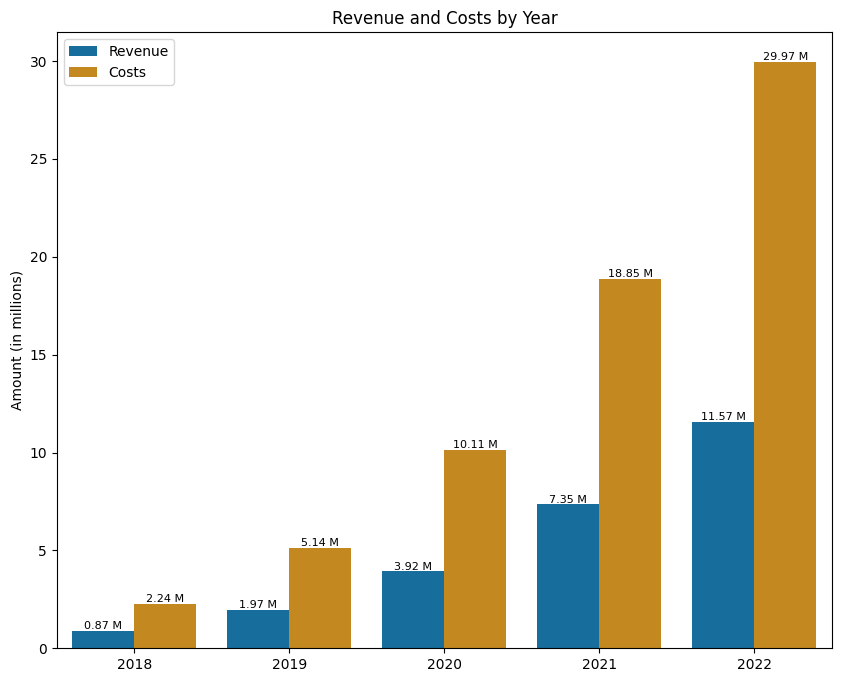

In [32]:
sns.set_palette('colorblind')

metrics_year_long = metrics_by_year.melt(id_vars='year', value_vars=['costs_M', 'revenue_M'], var_name='category', value_name='amount')

plt.figure(figsize=(10,8))

ax = sns.barplot(data=metrics_year_long, x='year', y='amount', hue='category')

plt.title('Revenue and Costs by Year')
plt.xlabel('')
plt.ylabel('Amount (in millions)')

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f M', size=8)
    
labels = ['Revenue', 'Costs']  
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='')


plt.show()

Both metrics have increased from 2018 to 2022. This was to be expected due to the growth of the product portfolio and the expansion into new markets during this period. The increase in those metrics suggests that the revenue more than doubled the costs each year. Let's examine the profit and profit margin for each year to see if there has been an increase in profitability. 

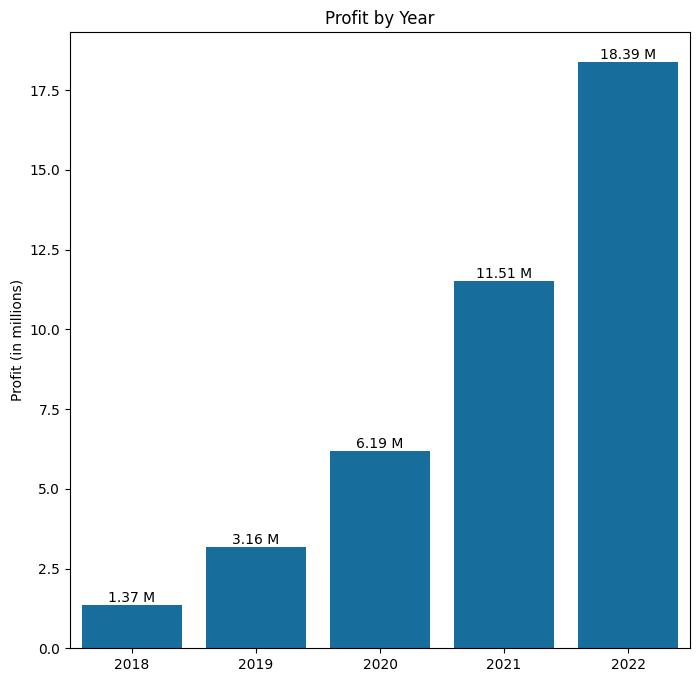

In [33]:
plt.figure(figsize=(8,8))

ax = sns.barplot(data=metrics_by_year, x='year', y='profit_M')

plt.title('Profit by Year')
plt.xlabel('')
plt.ylabel('Profit (in millions)')

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f M')

plt.show()

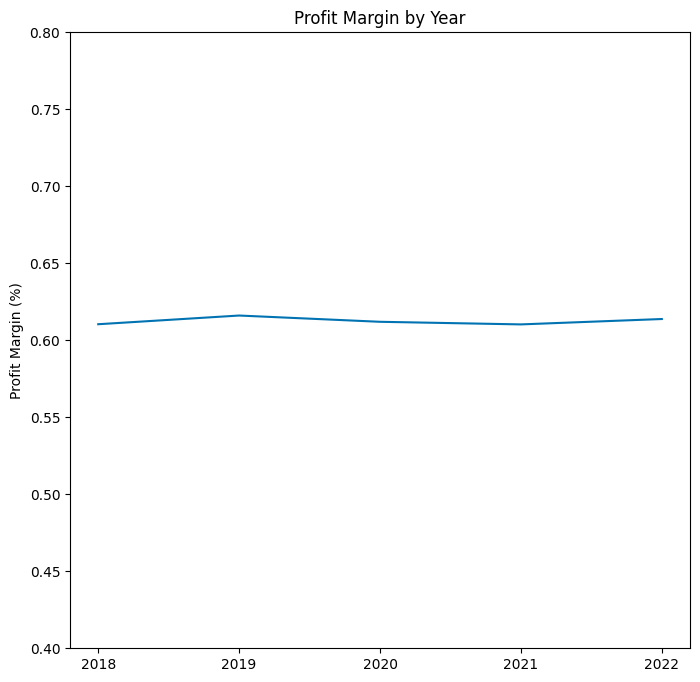

In [34]:
plt.figure(figsize=(8,8))

ax = sns.lineplot(data=metrics_by_year, x='year', y='profit_margin')

plt.title('Profit Margin by Year')
plt.xlabel('')
plt.ylabel('Profit Margin (%)')

ax.set_ylim(0.4, 0.8)
ax.set_xticks(metrics_by_year['year'].astype(int))

plt.show()

Although there is a significant increase in profit every year, the profit margin remains stable (at around 61%). This indicates that while the total earnings are growing, the proportion of profit relative to revenue is not changing much. 

In [35]:
total_costs = metrics_by_year['costs_M'].sum()
total_revenue = metrics_by_year['revenue_M'].sum()
total_profit = metrics_by_year['profit_M'].sum()

print('For the period 2018 - 2020:')
print()
print(f'The total cost is ${total_costs:.2f}M')
print(f'The total revenue is ${total_revenue:.2f}M')
print(f'The total profit is ${total_profit:.2f}M')

For the period 2018 - 2020:

The total cost is $25.69M
The total revenue is $66.31M
The total profit is $40.62M


 [⬆ Back to Contents](#back)

### Customer, Market and Channel Analysis <a id='customer'></a>

In this section we'll delve into the customer base. We will analyze the different sales platforms, channels and markets to identify their effectiveness and profitability.

In [36]:
query = """
WITH by_customer AS (
SELECT
    metrics.customer_code,
    TRIM(c.customer) AS customer,
    SUM(profit) AS profit
FROM
    metrics
JOIN
    dim_customer c
    ON metrics.customer_code = c.customer_code
GROUP BY
    TRIM(c.customer_code)
)

SELECT
    customer,
    SUM(profit) AS profit
FROM 
    by_customer
GROUP BY
    customer
"""

by_customer = pd.read_sql_query(query, con)
by_customer.head()

,customer,profit
0,Acclaimed Stores,7.087843e+05
1,All-Out,3.386603e+04
2,Amazon,5.624948e+06
3,Argos (Sainsbury's),1.567327e+05
4,Atlas Stores,1.658654e+05


In [37]:
top_customers = by_customer[['customer', 'profit']].sort_values(by='profit', ascending=False)[:15]
top_customers['profit_M'] = top_customers['profit'] / 1000000
top_customers

,customer,profit,profit_M
2,Amazon,5.624948e+06,5.624948
5,Atliq Exclusive,4.345581e+06,4.345581
6,Atliq e Store,3.626446e+06,3.626446
60,Sage,1.384828e+06,1.384828
34,Flipkart,1.368689e+06,1.368689
41,Leader,1.272186e+06,1.272186
19,Ebay,9.955646e+05,0.995565
24,Electricalsocity,8.345330e+05,0.834533
46,Neptune,8.302481e+05,0.830248
55,Propel,7.755212e+05,0.775521


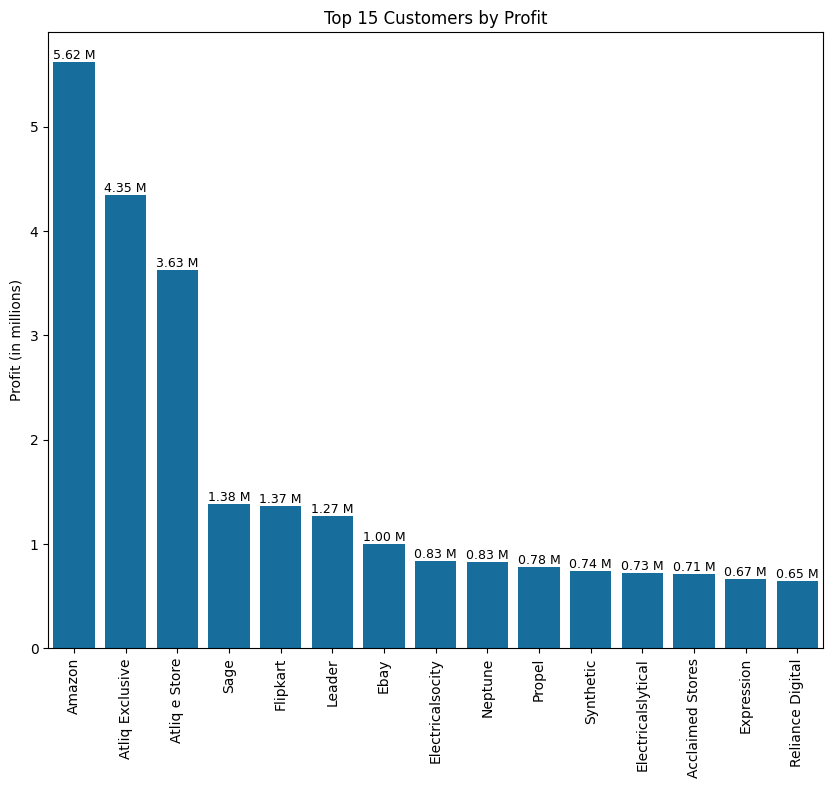

In [38]:
plt.figure(figsize=(10,8))

ax = sns.barplot(data=top_customers, x='customer', y='profit_M')

plt.title('Top 15 Customers by Profit')
plt.xlabel('')
plt.ylabel('Profit (in millions)')
plt.xticks(rotation=90, size=10)

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f M', fontsize=9)
    
plt.show()

Amazon, Atliq Exclusive and Atliq e Store are the top 3 customers, generating significantly higher profits than the subsequent customers. To better visualize which customers are contributing the most to the overall profit, let's plot a Pareto Driagram.

In [39]:
total_profit = by_customer['profit'].sum()

by_customer = by_customer.sort_values(by='profit', ascending=False).reset_index(drop=True)
by_customer['profit_M'] = by_customer['profit'] / 1000000
by_customer['percent'] = by_customer['profit'] / total_profit
by_customer['cumul_percent'] = by_customer['percent'].cumsum()
by_customer

,customer,profit,profit_M,percent,cumul_percent
0,Amazon,5.624948e+06,5.624948,0.138468,0.138468
1,Atliq Exclusive,4.345581e+06,4.345581,0.106974,0.245442
2,Atliq e Store,3.626446e+06,3.626446,0.089271,0.334713
3,Sage,1.384828e+06,1.384828,0.034090,0.368803
4,Flipkart,1.368689e+06,1.368689,0.033693,0.402496
...,...,...,...,...,...
69,Notebillig,7.271547e+04,0.072715,0.001790,0.995660
70,Integration Stores,6.904208e+04,0.069042,0.001700,0.997359
71,Electricalsbea Stores,5.481487e+04,0.054815,0.001349,0.998709
72,All-Out,3.386603e+04,0.033866,0.000834,0.999542


/var/folders/mg/hptp2zld5cl6kjcrwfys_p5h0000gn/T/ipykernel_54534/2230890215.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(by_customer['customer'], rotation=90, ha='center', size=8)


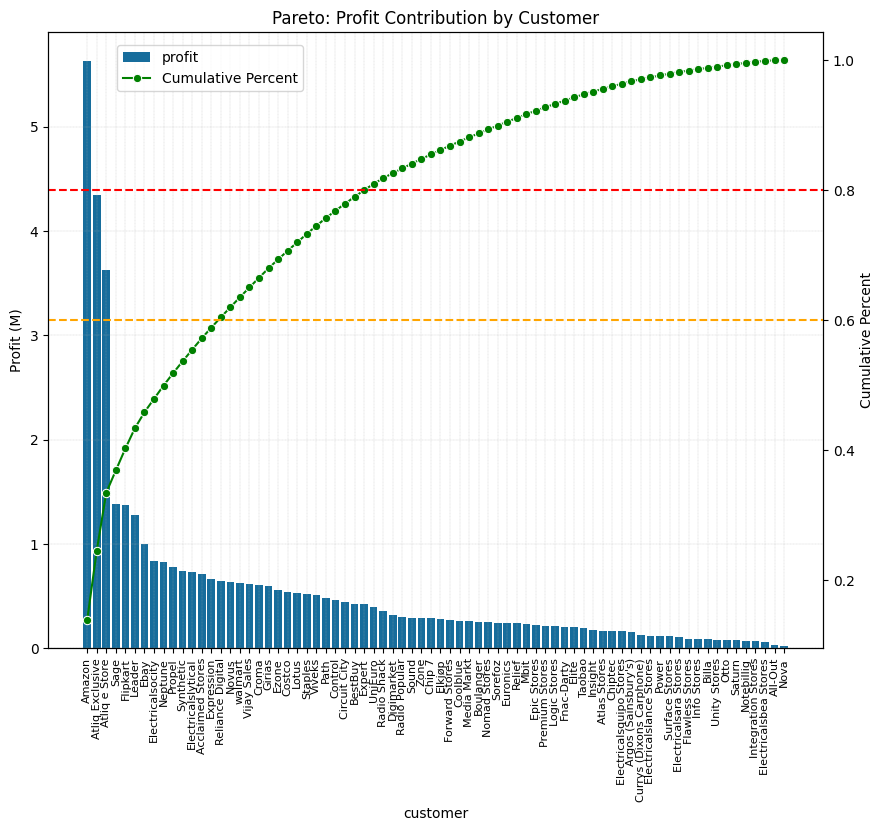

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=by_customer, x='customer', y='profit_M', ax=ax, label='profit')
ax2= ax.twinx()
sns.lineplot(data=by_customer, x='customer', y='cumul_percent', ax=ax2, marker='o', color='Green', label='Cumulative Percent', legend=False)

ax2.axhline(0.8,color='red', linestyle='--')
ax2.axhline(0.6,color='orange', linestyle='--')

ax.set_ylabel('Profit (M)')
ax2.set_ylabel('Cumulative Percent')
plt.title('Pareto: Profit Contribution by Customer')

ax.set_xticklabels(by_customer['customer'], rotation=90, ha='center', size=8)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.08, 0.99))

ax.grid(True, which='both', linestyle='--', linewidth=0.2)

plt.show()

Out of 74 customers, the 80% of the profit comes from 30 customers - which represents 40% of the customer base. Moreover, 60% of the profit was generated by just the top 15 customers.

Let's take a look at the profitability by channel.

In [41]:
query = """
SELECT
    *,
    total_profit / 1000000 AS total_profit_M,
    SUM(total_profit) OVER (PARTITION BY year) AS profit_year,
    total_profit / SUM(total_profit) OVER (PARTITION BY year) * 100 AS percent_profit_year
FROM 
    (
    SELECT
        year,
        channel,
        SUM(sold_quantity) AS sold_quantity,
        SUM(profit) AS total_profit
    FROM
        metrics m
    JOIN
        dim_customer c on m.customer_code = c.customer_code
    GROUP BY
        year,
        channel
    ORDER BY
        year,
        SUM(profit)
    ) 
"""
by_channel = pd.read_sql_query(query, con)
by_channel

,year,channel,sold_quantity,total_profit,total_profit_M,profit_year,percent_profit_year
0,2018,Distributor,25321,2.001351e+05,0.200135,1.369294e+06,14.615939
1,2018,Direct,24871,2.404484e+05,0.240448,1.369294e+06,17.560032
2,2018,Retailer,115079,9.287102e+05,0.928710,1.369294e+06,67.824028
3,2019,Distributor,50902,4.263293e+05,0.426329,3.163647e+06,13.475882
4,2019,Direct,61810,5.948793e+05,0.594879,3.163647e+06,18.803594
5,2019,Retailer,266807,2.142438e+06,2.142438,3.163647e+06,67.720524
6,2020,Distributor,71447,6.660322e+05,0.666032,6.188997e+06,10.761553
7,2020,Direct,113572,1.218347e+06,1.218347,6.188997e+06,19.685688
8,2020,Retailer,455565,4.304618e+06,4.304618,6.188997e+06,69.552759
9,2021,Distributor,118339,1.207976e+06,1.207976,1.150637e+07,10.498325


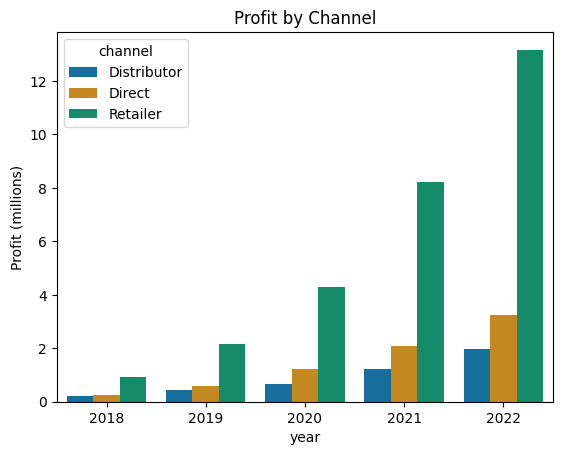

In [42]:
ax = sns.barplot(data=by_channel, x='year', y='total_profit_M', hue='channel')

plt.title('Profit by Channel')
plt.ylabel('Profit (millions)')
    
plt.show()

We observe an increase in profit across all channels, with the proportion of profit remaining relatively constant for each channel. The table shows a pattern in which around 67%-72% of the profit came from the Retailer channel each year. Next, let's look at the top markets for each year based on their profit. 

In [43]:
query = """
CREATE TEMPORARY TABLE IF NOT EXISTS by_market AS
SELECT
    *,
    total_profit / 1000000 AS total_profit_M,
    SUM(total_profit) OVER (PARTITION BY year) AS profit_year,
    total_profit / SUM(total_profit) OVER (PARTITION BY year) * 100 AS percent_profit_year
FROM 
    (
    SELECT
        year,
        market,
        SUM(sold_quantity) AS sold_quantity,
        SUM(profit) AS total_profit
    FROM
        metrics m
    JOIN
        dim_customer c on m.customer_code = c.customer_code
    GROUP BY
        year,
        market
    ORDER BY
        year,
        SUM(profit)
    ) 
"""
con.execute(query)

In [44]:
query = """
WITH ranked_market AS (
SELECT 
    year,
    market,
    sold_quantity,
    total_profit,
    total_profit / 1000000 AS total_profit_M,
    total_profit / SUM(total_profit) OVER (PARTITION BY year) * 100 AS percent_profit_year,
    ROW_NUMBER() OVER (PARTITION BY year ORDER BY total_profit DESC) AS rank
FROM
    by_market
)

SELECT
    *
FROM
    ranked_market
WHERE
    rank <= 5
"""
top_by_market = pd.read_sql_query(query, con)
top_by_market.head()

,year,market,sold_quantity,total_profit,total_profit_M,percent_profit_year,rank
0,2018,India,73463,605079.008034,0.605079,44.189132,1
1,2018,USA,30842,253117.489611,0.253117,18.485259,2
2,2018,South Korea,27378,228719.633175,0.228720,16.703475,3
3,2018,Australia,7484,62237.975464,0.062238,4.545261,4
4,2018,France,7101,59629.924141,0.059630,4.354794,5


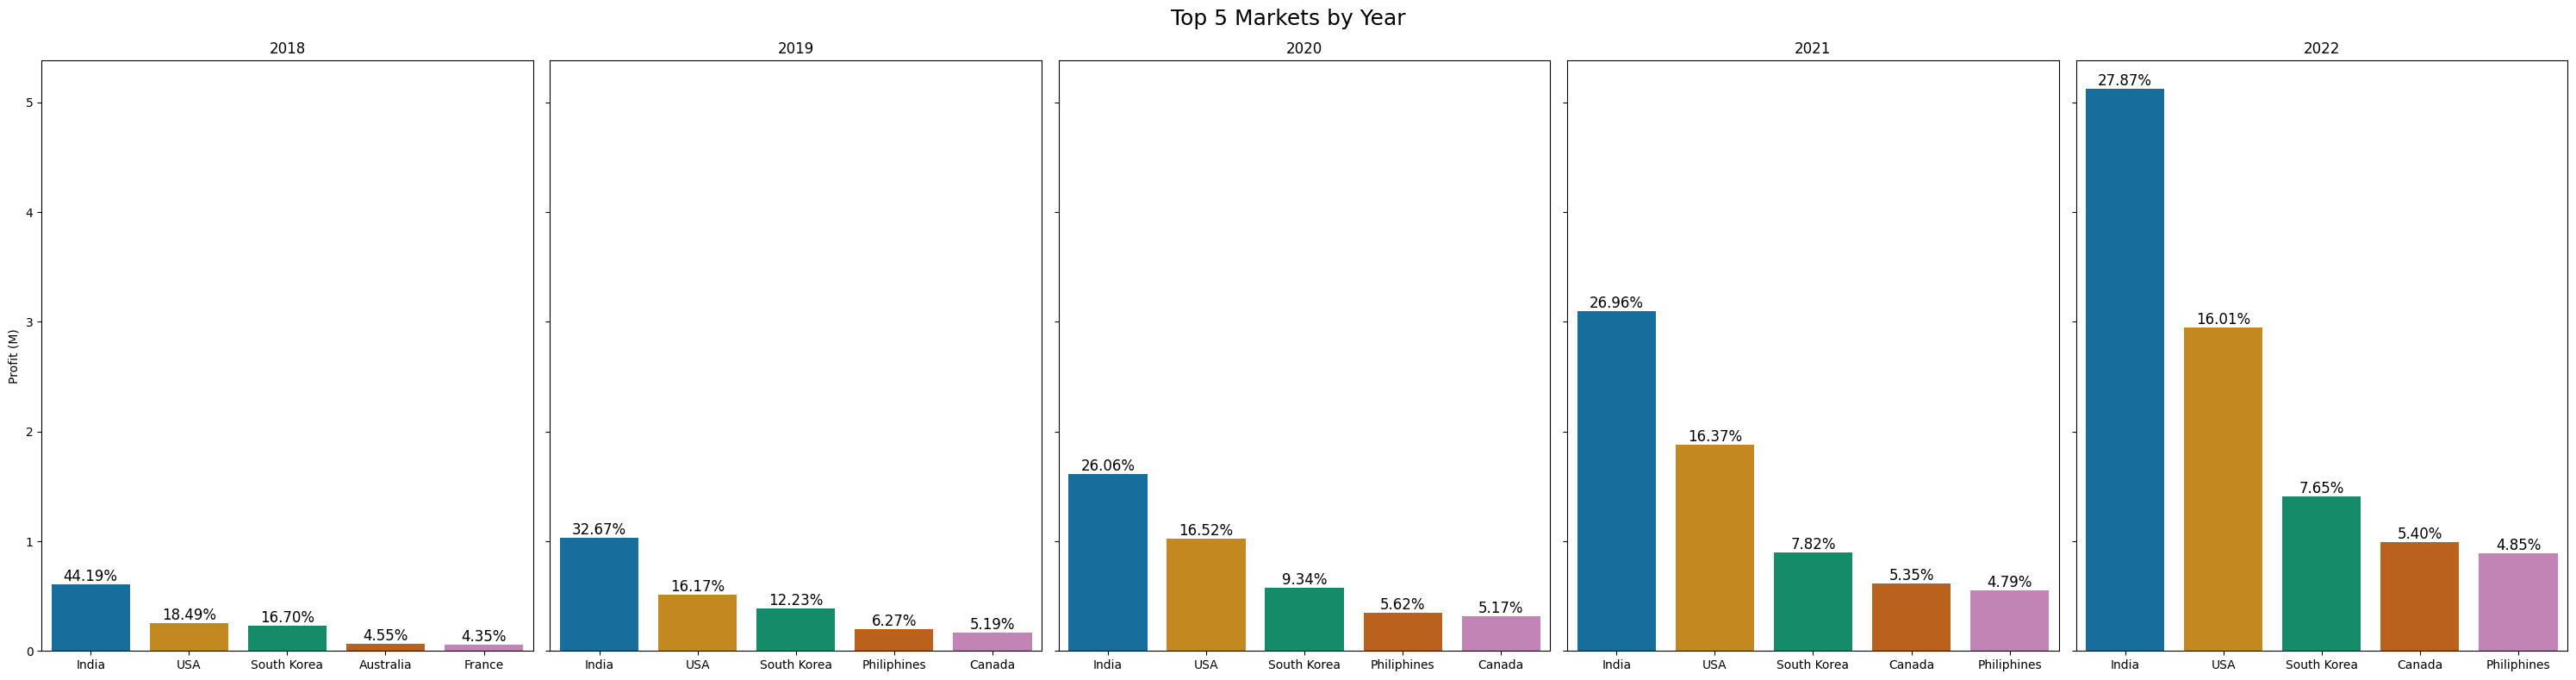

In [45]:
unique_years = top_by_market['year'].unique()
n_years = len(unique_years)

fig, axes = plt.subplots(1, n_years, figsize=(n_years * 6, 8), sharey=True)

for ax, year in zip(axes, unique_years):
    subset = top_by_market[top_by_market['year'] == year]
    sns.barplot(data=subset, x='market',y='total_profit_M', hue='market', ax=ax)
    ax.set_title(f'{year}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_ylabel('Profit (M)')
    
    for patch, percent in zip(ax.patches, subset['percent_profit_year']):
        height = patch.get_height()
        ax.annotate(f'{percent:.2f}%', (patch.get_x() + patch.get_width() / 2., height),
                   ha='center', va='bottom', size=12)

fig.suptitle('Top 5 Markets by Year', fontsize=18)

plt.tight_layout()
plt.show()

India, the USA and South Korea are the predominant markets in terms of profit for every year from 2018 to 2022. The percentage of the profit from these markets has decreased over time potentially due to the introduction and growth of other markets. However, these 3 markets still contribute more than 50% of the profit for each year. Australia and France were in the 4th and 5th positions only in 2018. In the following years, these positions were occupied between the Philiphines and Canada, with Canada surpassing the Philiphines in the last two years.

 [⬆ Back to Contents](#back)

### Product Category and Segment Analysis <a id='product'></a>

In this section, we will explore AtliQ's product categories and segments to understand their contribution to the overall profitability and identify opportunities for improvement. 

In [46]:
query = """
SELECT
    year,
    category,
    SUM(sold_quantity) / 1000.0 AS sold_quantity_T,
    SUM(profit) / 1000000 AS total_profit_M
FROM
    metrics m 
JOIN
    dim_product p ON m.product_code = p.product_code
GROUP BY
    year, 
    category
"""

by_category = pd.read_sql_query(query, con)
by_category

,year,category,sold_quantity_T,total_profit_M
0,2018,Graphic Card,91.366,0.736947
1,2018,Internal HDD,73.905,0.632347
2,2019,Graphic Card,127.361,0.947986
3,2019,Internal HDD,252.158,2.215661
4,2020,Graphic Card,137.869,1.112035
5,2020,Internal HDD,502.715,5.076962
6,2021,Graphic Card,77.857,0.715892
7,2021,Internal HDD,980.086,10.790474
8,2022,Graphic Card,218.083,2.201369
9,2022,Internal HDD,1321.535,16.193070


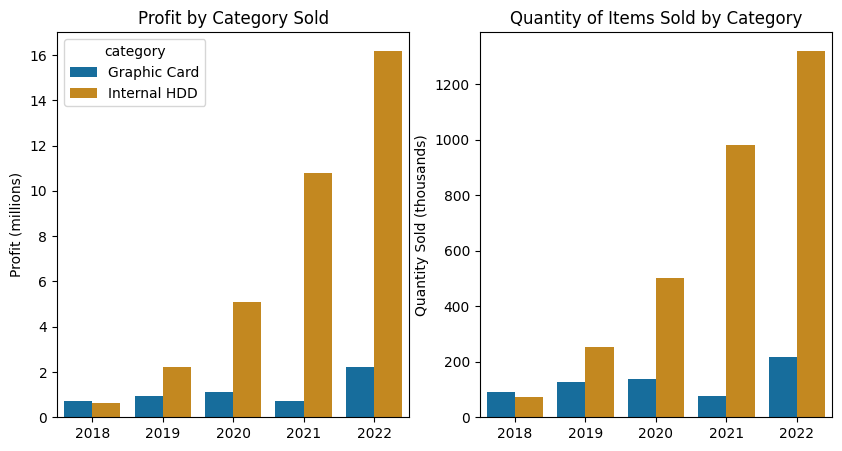

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(data=by_category, x='year', y='total_profit_M', hue='category', ax=ax1)
ax1.set_title('Profit by Category Sold')
ax1.set_xlabel('')
ax1.set_ylabel('Profit (millions)')

sns.barplot(data=by_category, x='year', y='sold_quantity_T', hue='category', ax=ax2, legend=False)
ax2.set_title('Quantity of Items Sold by Category')
ax2.set_xlabel('')
ax2.set_ylabel('Quantity Sold (thousands)')

plt.show()

Out of 14 categories of products, only 2 have been sold every year from 2018 to 2022: Graphics Card and Internal HDD. After 2018, Internal HDD has consistently been sold and produced more profit than Graphics Cards, except in 2021, when Graphic Cards experienced a small decrease compared to the previous year.

In [48]:
query = """
SELECT
    year,
    segment,
    SUM(sold_quantity) / 1000.0 AS sold_quantity_T,
    SUM(profit) / 1000000 AS total_profit_M
FROM
    metrics m 
JOIN
    dim_product p ON m.product_code = p.product_code
GROUP BY
    year, 
    segment
"""

by_segment = pd.read_sql_query(query, con)
by_segment

,year,segment,sold_quantity_T,total_profit_M
0,2018,Peripherals,165.271,1.369294
1,2019,Peripherals,379.519,3.163647
2,2020,Peripherals,640.584,6.188997
3,2021,Peripherals,1057.943,11.506366
4,2022,Peripherals,1539.618,18.394439


Let's also explore the cost of each product to identify those that represent the biggest expenses for the company.

In [49]:
query = """
WITH cost_price_product AS (
SELECT
    year,
    m.product_code,
    SUM(sold_quantity) AS sold_quantity,
    manufacturing_cost,
    p.gross_price
FROM
    metrics m 
JOIN fact_manufacturing_cost c ON m.product_code = c.product_code AND m.year = c.cost_year
JOIN fact_gross_price p ON m.product_code = p.product_code AND m.year = p.fiscal_year
GROUP BY 1, 2
)

SELECT
    cp.*,
    product,
    variant,
    ROW_NUMBER() OVER (PARTITION BY year ORDER BY sold_quantity DESC) AS rank
FROM 
    cost_price_product cp
JOIN
    dim_product p ON cp.product_code = p.product_code
"""

price_product = pd.read_sql_query(query, con)
price_product.head()

,year,product_code,sold_quantity,manufacturing_cost,gross_price,product,variant,rank
0,2018,A0418150103,23667,5.2379,17.8449,AQ Mforce Gen X,Standard 3,1
1,2018,A0418150104,23542,5.3666,18.6457,AQ Mforce Gen X,Plus 1,2
2,2018,A0418150102,22315,5.0082,16.6281,AQ Mforce Gen X,Standard 2,3
3,2018,A0418150101,21842,4.7713,15.8753,AQ Mforce Gen X,Standard 1,4
4,2018,A0118150103,18754,5.9469,19.3630,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium,5


In [50]:
price_product['product_variant'] = price_product['product'] + ' - ' + price_product['variant']
price_product['top_3'] = price_product['rank'] <= 5

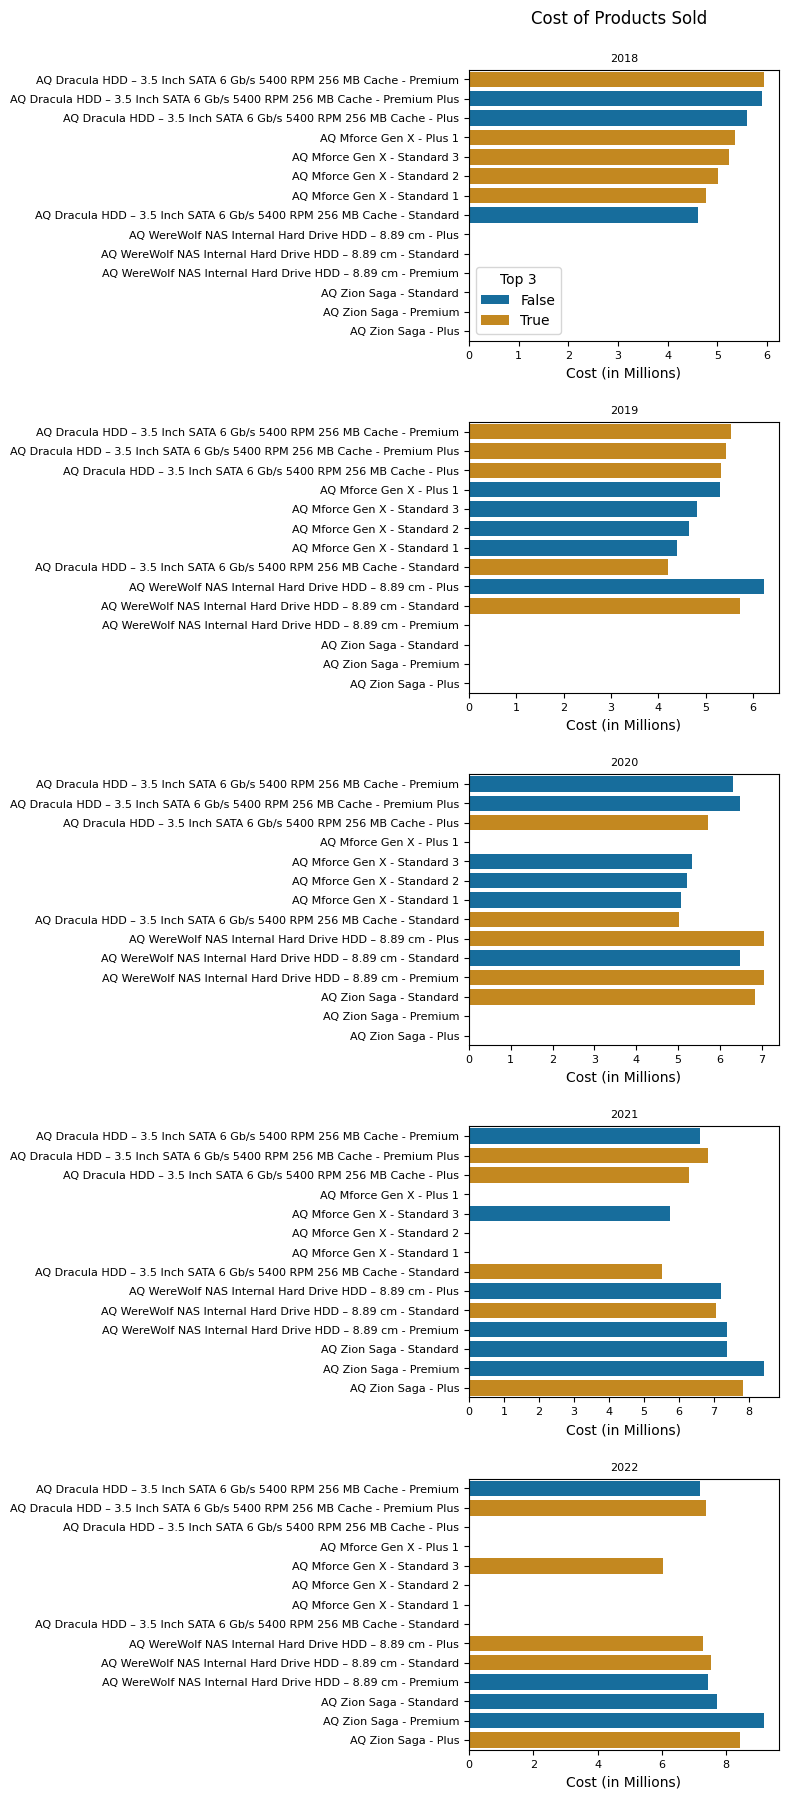

In [51]:
unique_years = price_product['year'].unique()
n_years = len(unique_years)

fig, axes = plt.subplots(n_years, 1, figsize=(4, n_years * 4), sharey=True)

for i, (ax, year) in enumerate(zip(axes, unique_years)):
    subset = price_product[price_product['year'] == year].sort_values(by='manufacturing_cost', ascending=False)
    sns.barplot(data=subset, x='manufacturing_cost', y='product_variant', hue='top_3', ax=ax)
    ax.set_title(year, fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('Cost (in Millions)')
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    if i == 0:
        ax.legend(title='Top 3')
    else:
        ax.get_legend().remove()

plt.subplots_adjust(top=0.95, hspace=0.3)
fig.suptitle('Cost of Products Sold', fontsize=12)
    
plt.show()

It appears that there is no consistent pattern between the manufacturing costs and the top-selling products. In some years, the top-selling product has the lowest manufacturing cost, while in other years, the product with the highest cost is among the top sellers. Although the most frequently sold items are nos necessarily those with the highest manufacturing costs, optimizing manufacturing costs may be an important approach to consider to increase overall profitability. This can be achieved through the optimization of the supply chain, the improvement of the production process, economy of scale and other strategies. It is important to maintain the quality standards when applying a strategy for cost reduction, to ensure competitiveness in addition to the potential increase in profitability.

 [⬆ Back to Contents](#back)

### Discount Analysis <a id='discount'></a>

This section will focus on evaluating the impact of discounts on AtliQ's sales and profitability. We will assess how the discount strategies influence sales volumes and profit, and determine if adjustments to these strategies might be required. We will start by calculating the average discount for each customer throughout 2018 - 2022.

In [52]:
query = """
SELECT
    TRIM(customer) AS customer,
    AVG(discount) AS discount_avg
FROM
    metrics m
JOIN 
    dim_customer c ON m.customer_code = c.customer_code
GROUP BY 
    1
"""

avg_discount_customer = pd.read_sql_query(query, con)
avg_discount_customer.sort_values(by='discount_avg', ascending=False).head(10)

,customer,discount_avg
48,Notebillig,0.288718
50,Novus,0.285633
32,Ezone,0.283653
71,Viveks,0.276937
49,Nova,0.275187
33,Flawless Stores,0.270031
20,Electricalsara Stores,0.269729
15,Costco,0.269095
69,Unity Stores,0.268692
59,Relief,0.264980


The average discounts of the customer with the highest values range between 25% and 29%. Let's take a look at the relationship between the average discount and the average profit margin by customer to understand how discount levels impact profitability.

In [53]:
query = """
WITH metrics_year AS (
SELECT
    year, 
    TRIM(customer) AS customer,
    SUM(profit) AS profit,
    SUM(sales) AS sales,
    SUM(profit) /SUM(revenue) AS profit_margin
FROM metrics m 
JOIN dim_customer c
    ON c.customer_code = m.customer_code
GROUP BY
    1, 2
)

SELECT
    my.customer AS customer,
    discount_avg,
    AVG(sales) / 1000000 AS sales_avg_M,
    AVG(profit) / 1000000 AS profit_avg_M,
    AVG(profit_margin) AS profit_margin_avg
FROM
    (
    SELECT
        TRIM(customer) AS customer,
        AVG(discount) AS discount_avg
    FROM
        metrics m
    JOIN 
        dim_customer c ON m.customer_code = c.customer_code
    GROUP BY 
        1
    ) AS discounts
JOIN
    metrics_year my ON my.customer = discounts.customer
GROUP BY 
    1
    
"""
discount_profit = pd.read_sql_query(query, con)
discount_profit.sort_values(by='discount_avg')

,customer,discount_avg,sales_avg_M,profit_avg_M,profit_margin_avg
5,Atliq Exclusive,0.090807,1.460974,0.869116,0.665576
16,Croma,0.214300,0.247722,0.120143,0.621576
8,Billa,0.223400,0.046553,0.021565,0.616279
39,Insight,0.224396,0.067503,0.033964,0.613317
29,Euronics,0.224679,0.101086,0.047760,0.620196
...,...,...,...,...,...
49,Nova,0.275187,0.014415,0.006195,0.590818
71,Viveks,0.276937,0.241800,0.101554,0.587857
32,Ezone,0.283653,0.267385,0.111076,0.585090
50,Novus,0.285633,0.306789,0.125946,0.584209


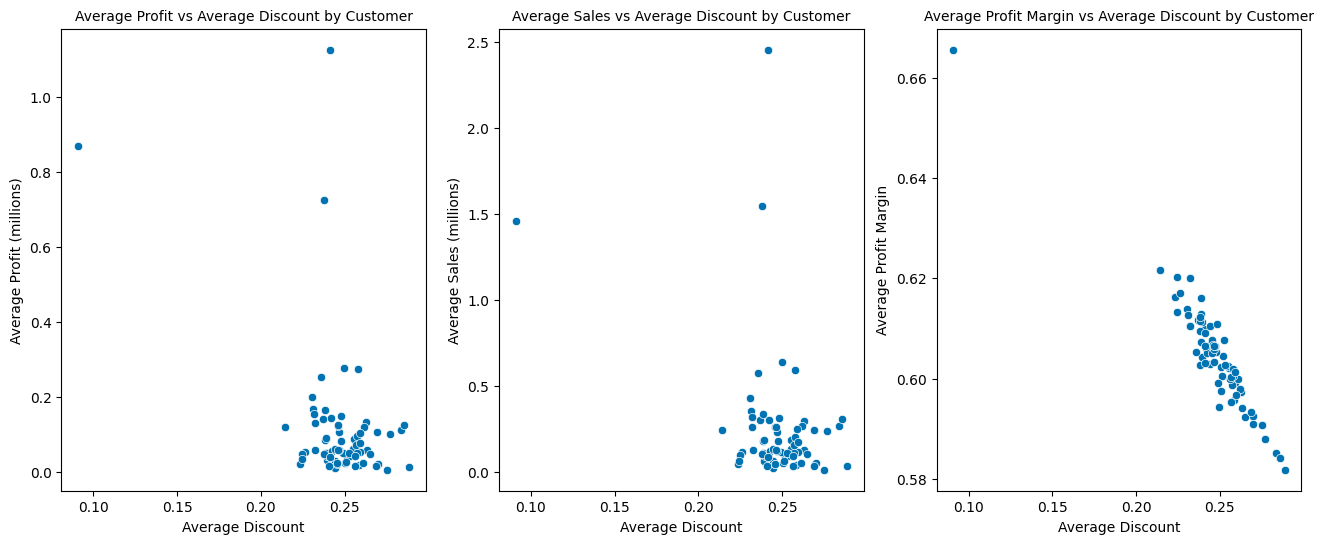

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.scatterplot(data=discount_profit, x='discount_avg', y='profit_avg_M', ax=axes[0])
axes[0].set_title('Average Profit vs Average Discount by Customer', size=10)
axes[0].set_ylabel('Average Profit (millions)')
axes[0].set_xlabel('Average Discount')

sns.scatterplot(data=discount_profit, x='discount_avg', y='sales_avg_M', ax=axes[1])
axes[1].set_title('Average Sales vs Average Discount by Customer', size=10)
axes[1].set_ylabel('Average Sales (millions)')
axes[1].set_xlabel('Average Discount')

sns.scatterplot(data=discount_profit, x='discount_avg', y='profit_margin_avg', ax=axes[2])
axes[2].set_title('Average Profit Margin vs Average Discount by Customer', size=10)
axes[2].set_ylabel('Average Profit Margin')
axes[2].set_xlabel('Average Discount')

plt.show()

In the fisrt scatterplot we can observe a wide range of average profit among customers, even at similar discount levels. This chart also supports what we previously saw, that only a few customers generate significantly higher profits. There appears to be no correlation between the average discount and the average profit. The average sales shows a similar pattern, with no obvious correlation with the discount. This suggests that higher discounts doesn't necessarilly drive higher sales. However, when we look at the last scatterplot, we can see a clear negative correlation between the average discounts and the average profit margin. Customers that tend to receive higher discounts tend to have lower profit margins. This is to expect, as discounts reduce the revenue without affecting the costs.

These findings suggest that while discounts negatively impact profit margins, they don't necessarily lead to higher sales, and that sales volume might be affected by other factors. This highlights the importance of balancing discount strategies to maintain adequate levels of profitability.

 [⬆ Back to Contents](#back)

## Hypothesis Testing <a id='hypothesis'></a>

In this final section of the analysis, we will perform hypohesis testing to validate or refute assumptions derived from the data. We had formulated 3 hypotheses during the elaboration of the research plan. However, after exploring the data, only the following hypotheses are still relevant:

**Hypothesis 1:**

`H₀: There is no significant difference in revenue growth between domestic and internation markets.`

`H₁: There is a signiican diffeence in revenue frowth between domestic and international markets.`


**Hypothesis 2:**

`H₀: Profit margins are not significantly higher for E-Commerce platforms compared to Brick and Mortar.`

`H₁: Profit margins are  significantly higher for E-Commerce platforms compared to Brick and Mortar.`

### Hypothesis 1

In [55]:
query = """
WITH market_revenue AS (
SELECT
    year,
    market,
    CASE WHEN market = 'India' THEN 1 ELSE 0 END AS domestic_market,
    SUM(revenue) AS revenue
FROM
    metrics m
JOIN dim_customer c ON m.customer_code = c.customer_code

GROUP BY
    1, 2
)

SELECT
    year,
    domestic_market,
    SUM(revenue) AS revenue
FROM
    market_revenue
GROUP BY
    1, 2
"""

market_data = pd.read_sql_query(query, con)
market_data.head()

# in the column domestic_market, 1 is domestic market (India) and 0 is international market (other than India).

,year,domestic_market,revenue
0,2018,0,1.250168e+06
1,2018,1,9.930155e+05
2,2019,0,3.446661e+06
3,2019,1,1.688561e+06
4,2020,0,7.486769e+06


In [56]:
market_data['revenue_growth'] = market_data.groupby('domestic_market')['revenue'].pct_change()
revenue_growth = market_data.dropna()
revenue_growth['revenue_growth'] = revenue_growth['revenue_growth'] * 100
revenue_growth

/var/folders/mg/hptp2zld5cl6kjcrwfys_p5h0000gn/T/ipykernel_54534/736925814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue_growth['revenue_growth'] = revenue_growth['revenue_growth'] * 100


,year,domestic_market,revenue,revenue_growth
2,2019,0,3.446661e+06,175.695826
3,2019,1,1.688561e+06,70.043808
4,2020,0,7.486769e+06,117.218003
5,2020,1,2.625924e+06,55.512477
6,2021,0,1.374582e+07,83.601461
7,2021,1,5.107547e+06,94.504782
8,2022,0,2.158131e+07,57.002720
9,2022,1,8.386610e+06,64.200334


In [57]:
domestic_growth = revenue_growth[revenue_growth['domestic_market'] == 1]['revenue_growth']
international_growth = revenue_growth[revenue_growth['domestic_market'] == 0]['revenue_growth']

In [58]:
def hypothesis_check(group1, group2, alpha=0.05):
    
    # Normality test and homogeneity of variance
    # Perform Shapiro-Wilk test for normality
    shapiro_1 = stats.shapiro(group1)
    shapiro_2 = stats.shapiro(group2)

    if shapiro_1.pvalue > alpha and shapiro_2.pvalue > alpha:
        # if both distributions are normal
        # perform Levene's test for homogeneity of variance
        levene = stats.levene(group1, group2)

        if levene.pvalue < alpha:
            # if the variances are not equal
            # perform t-test without assuming equal variance
            test_result = stats.ttest_ind(group1, group2, equal_var=False)
        else:
            # if the variances are equal
            # perform t-test assuming equal variance
            test_result = stats.ttest_ind(group1, group2, equal_var=True)

    else:
        # if normality is not met for both samples
        # perform Mann-Whitney test 
        test_result = stats.mannwhitneyu(group1, group2)

    # determine the results of the test based on on p-value and alpha
    if test_result.pvalue < alpha:
        result = f'With a p value of {test_result.pvalue:.4f}, we reject the Null Hypothesis.'
    else:
        result = f'With a p-value of {test_result.pvalue:.4f}, we fail to reject the Null Hypothesis.'
        
    return result

In [59]:
hyp1 = hypothesis_check(domestic_growth, international_growth)
hyp1

'With a p-value of 0.2152, we fail to reject the Null Hypothesis.'

Based on the results of the statistical test, we don't have enough evidence to conclude that there is a significant difference in revenue growth between domestic and international markets. 

### Hypotesis 2

In [60]:
query = """
SELECT
    year,
    platform,
    SUM(profit) / SUM(revenue) AS profit_margin
FROM
    metrics m
JOIN dim_customer c on c.customer_code = m.customer_code
GROUP BY
    1, 2
"""

platform_data = pd.read_sql_query(query, con)
platform_data

,year,platform,profit_margin
0,2018,Brick & Mortar,0.611397
1,2018,E-Commerce,0.608048
2,2019,Brick & Mortar,0.615958
3,2019,E-Commerce,0.616338
4,2020,Brick & Mortar,0.611816
5,2020,E-Commerce,0.612311
6,2021,Brick & Mortar,0.611500
7,2021,E-Commerce,0.607272
8,2022,Brick & Mortar,0.616551
9,2022,E-Commerce,0.606431


In [61]:
bricks_profit = platform_data[platform_data['platform'] == 'Brick & Mortar']['profit_margin']
ecom_profit = platform_data[platform_data['platform'] == 'E-Commerce']['profit_margin']

In [62]:
hyp2 = hypothesis_check(bricks_profit, ecom_profit)
hyp2

'With a p-value of 0.3095, we fail to reject the Null Hypothesis.'

Based on the result of the test, we can say that the profit margins for both platforms, Bricks and Mortar and E-Commerce, are statistically similar for these years. 

## Conclusion <a id='conclusion'></a>

After conducting a comprehensive analysis of different financial aspects of AtliQ, several key insights have emerged. Our analysis reveals a consistent increase in profit every year, yet the profit margin has remained stable. This indicates that both the costs and revenues have increased proportionally. While this stability might suggest financial health, it is important to note that for this analysis we have only considered the manufaturing costs of the products sold, without taking into account unsold inventory or administrative expenses (payroll, utilities, taxes and others).

Our analysis also reveals that India, the USA and South Korea remain the dominant markets in terms of profit, consistently contributing to more than 50% of the overall profit each year. Although their share have decreased over time, these markets continue to be crucial for AtliQ's profitability.

In terms of products, there is no consistent correlation between manufacturing cost and top-selling products. It is essential to explore additional factors that might influence sales, to determine a right strategy to enhance profitability. 

The analysis of discounts shows a clear negative correlation between average discounts and profit margins. It is recommended to reassess discount strategies to maintain a balance between competitiveness and profitability. 

Furthermore, hypothesis testing results indicate that there is no significant difference in revenue growth between dosmestic and international markets. This suggests that even though the growth of the international markets have been constant, the national market remains equally relevant. Additionally, the testing results also reveal that the profit margins of the different platforms (E-Commerce and Brick & Mortar) are statistically similar.

In light of these findings, we recommend focusing on optimizing discount strategies, exploring additional factors influencing sales, and managing manufacturing costs effectively. In addition, we advise regular reviews of the overall performance to maintain the team informed to guide decision-making to enhance profitability and growth. For this purpose, we have created an interactive dashboard, to monitor Year over Year financial performance. This dashboard can be accesses by clicking [here](https://public.tableau.com/views/AtliQFinancialAnalysis/Overview?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link).

 [⬆ Back to Contents](#back)